In [1]:
%matplotlib inline

import scipy as sci
import scipy.special as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colors
from matplotlib.patches import Rectangle, Circle
from sklearn.linear_model import OrthogonalMatchingPursuit
import cvxpy as cp

def db(x):
    return 20*np.log10(np.absolute(x))

#Spherical Hankel function of second kind
def hn2(n, x, derivative=True):
    if derivative:
        h = sp.spherical_jn(n, x, derivative=True) - 1j*sp.spherical_yn(n, x, derivative=True)
    else:
        h = sp.spherical_jn(n, x) - 1j*sp.spherical_yn(n, x)
    
    return h
                
def Rn(n, kr, kr_a):
    rn = 4*np.pi*((1j)**n)*(sp.spherical_jn(n, kr) - hn2(n, kr, derivative=False)*sp.spherical_jn(n, kr_a, derivative=True)/hn2(n, kr_a, derivative=True))
    
    return rn

#Matrix of Spherical Harmonics
def harm(N, theta, phi):
    Q = theta.shape[0]
    Y = np.zeros((Q, N+1, (2*N+1)+1), dtype='complex')
    
    for q in range(Q):
        for n in range(N+1):
            for m in range(2*n+1):
                Y[q][n][m] = sp.sph_harm(m-n, n, phi[q], theta[q])
                
    return Y

#The sound pressure can be obtained with (mic=True) or without (mic=False) the presence of a rigid microphone array
def pressure(kr, kr_a, Y, a_s, Y_s, mic):
    N = Y.shape[1] - 1
    p = np.zeros((Y.shape[0],1), dtype=complex)
    
    for i in range(Y.shape[0]):
        sum_n = 0
        
        for n in range(N+1):
            sum_m = 0
            if mic:
                R = Rn(n, kr, kr_a)
            else:
                R = 4*np.pi*((1j)**n)*sp.spherical_jn(n, kr)
                
            for m in range(2*n+1):
                sum_s = 0
                
                for s in range(a_s.shape[0]):
                    sum_s = sum_s + a_s[s]*np.conj(Y_s[s][n][m])
                
                sum_m = sum_m + sum_s*R*Y[i][n][m]

            sum_n = sum_n + sum_m

        p[i][0] = sum_n
        
    return p

#p_nm Spherical Fourier Transform coefficients of the sound pressure
def fourier(p, Y):
    N = Y.shape[1] - 1
    Q = p.shape[0]
    pnm = np.zeros((N+1, (2*N+1)+1), dtype='complex')
    
    for n in range(N+1):
        for m in range(2*n+1):
            sum_q = 0

            for q in range(Q):
                sum_q = sum_q + p[q][0]*np.conjugate(Y[q][n][m])

            pnm[n][m] = (4*np.pi/Q)*sum_q
        
    return pnm

# Simple Spherical Beamforming

A spherical spatial filter, also known as beamforming, is defined by the integration of the sound pressure over a spherical region of the space weighted by a function  $w(k, \theta, \phi)$ at the same region

\begin{equation}
y = \int_0^{2\pi}\int_0^{\pi}[w(k, \theta, \phi)]^*p(k, r, \theta, \phi)\,\sin\theta \,d\theta \,d\phi.
\label{eq.sphfilter}
\end{equation}

The main intent is to accentuate the signal from the interest area and to atenuate the signals from other areas. The equation above can be written in terms of the SFT coefficients

\begin{equation}
    y = \sum_{n=0}^{\infty}\sum_{m=-n}^{n}[w_{nm}]^*p_{nm}.
\label{eq.beamesferico}
\end{equation}
where $w_{nm}$ are the spherical harmonics coefficients that describe $w(k, \theta, \phi)$. 

A simple spherical beamforming which accentuates the signals from the areas where sound sources are located can be obtained with the following weights

\begin{equation}
[w_{nm}(k)]^* = \frac{Y_{n}^{m}(\theta_v, \phi_v)}{R_n(kr)}
\label{eq.pesoesferico}
\end{equation}
where $(\theta_v, \phi_v)$ are the array look direction. The division by $R_n(kr)$ removes the rigid spherical array effect on the sound field.

In [2]:
def beam(kr, kr_a, pnm):
    N = pnm.shape[0] - 1
    delta = 100
    theta_v = np.arange(0, np.pi + np.pi/delta, np.pi/delta)
    phi_v = np.arange(0, 2*np.pi + 2*np.pi/delta, 2*np.pi/delta)
    b = np.zeros((delta + 1, delta + 1), dtype='complex')
    
    for i in range(delta + 1):
        for j in range(delta + 1):
            sum_n = 0

            for n in range(N+1):
                R = Rn(n, kr, kr_a)
                sum_m = 0

                for m in range(2*n+1):
                    sum_m = sum_m + pnm[n][m]*sp.sph_harm(m-n, n, phi_v[j], theta_v[i])

                sum_n = sum_n + sum_m/R

            b[i][j] = sum_n

    return theta_v, phi_v, b

A sound scene with $S = 3$ plane waves is simulated. The amplitudes are $(1.0, 0.7e^{j\pi/2}, 0.4e^{j\pi/2})$ arriving from $[(90^\circ, 45^\circ), (117^\circ, 90^\circ), (45^\circ, 270^\circ)]$. The wave number and the array radius satisfy $kr_a = 6$. The sampling is made by a rigid spherical microphone array of $Q = 64$ microphones with nearly-uniform distribuition. The truncation is made at $N = 7$.

θ =  90.0 ϕ =  45.0
θ =  117.0 ϕ =  90.0
θ =  45.0 ϕ =  270.0


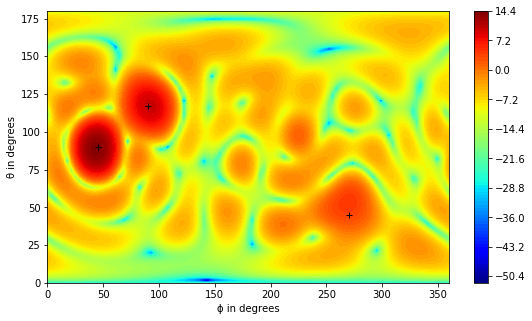

In [3]:
#Nearly-uniform ditribuition over a sphere extracted from https://stackoverflow.com/a/44164075
def dist(num_points):
    indices = np.arange(0, num_points, dtype=float) + 0.5
    theta = np.arccos(1 - 2*indices/num_points)%(np.pi)
    phi = (np.pi * (1 + 5**0.5) * indices)%(2*np.pi)
    
    return theta, phi

Q = 64
N = 7
kr_a = 6
a_s = np.array([1.0, 0.7*np.exp(1j*np.pi/3), 0.4*np.exp(1j*np.pi/2)])
theta_s = np.array([np.pi/2, 13*np.pi/20, np.pi/4]) #90, 117 e 45 graus
phi_s = np.array([np.pi/4, np.pi/2, 3*np.pi/2]) #45, 90 e 270 graus

theta_q, phi_q = dist(Q)
Y_q = harm(N, theta_q, phi_q)
Y_s = harm(N, theta_s, phi_s)
p = pressure(kr_a, kr_a, Y_q, a_s, Y_s, mic=True)
pnm = fourier(p, Y_q)
theta_v, phi_v, img = beam(kr_a, kr_a, pnm)

plt.figure(figsize=(9,5))
for i in range(theta_s.shape[0]):
    print('θ = ',(180/np.pi)*theta_s[i], 'ϕ = ', (180/np.pi)*phi_s[i])
    plt.plot((180/np.pi)*phi_s[i], (180/np.pi)*theta_s[i], color='black', marker='+')
    
cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar= plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

# Sparse Decomposition

## 1. Sensing Matrix

Given the sound pressure at each microphone

\begin{equation}
p(k, r_a, \theta_q, \phi_q) = \sum_{s=1}^{S}\sum_{n=0}^{N}\sum_{m=-n}^{n}R_n(kr_a,kr_a)a_s(k)[Y_n^m(\theta_s, \phi_s)]^*Y_n^m(\theta_q, \phi_q),
\end{equation}
it is possible to choose a grid with $L$ directions and rewrite the equation above as a matrix multiplication. We define $\mathbf{p}_{Q\times 1}$ = $[p(\Omega_1), \dots, p(\Omega_Q)]^T$ as the sound pressure vector where $p(\Omega_q)$ is the mesured pressure at the microphone. Thus,

\begin{equation}
\begin{aligned}
\textbf{p} = \textbf{Ab} =
\begin{bmatrix} 
g(\Omega_1, \Omega_1) & \dots & g(\Omega_1, \Omega_L)\\
\vdots & g(\Omega_q, \Omega_l) & \vdots\\
g(\Omega_Q, \Omega_1) & \dots & g(\Omega_Q, \Omega_L)
\end{bmatrix} 
\begin{bmatrix}
b_1 \\
\vdots \\
b_L
\end{bmatrix},
\end{aligned}
\end{equation}
where
\begin{equation}
\begin{aligned}
g(\Omega_q, \Omega_l) =  
\sum_{n=0}^{N}R_n(kr_a, kr_a)\sum_{m=-n}^{n}Y_{n}^{m}(\Omega_l)^*Y_{n}^{m}(\Omega_q).
\end{aligned}
\label{eq.matrizsens_g}
\end{equation}

It is defined $(\Omega_l) = (\theta_l, \phi_l)$, $l = 0, \dots, L$ as the $l$ direction of the grid. $g(\Omega_q, \Omega_l)$ is the $(q,l)$ element of the sensing matrix $\mathbf{A}_{Q\times L}$. $\mathbf{b}_{L\times 1}$ = $[b_1, \dots, b_L]^T$ is the vector that contains the complex amplitudes of each grid point and non-zero entries only when the positions $(\Omega_l)$ and $(\Omega_s)$ concur, where $b_l = a_s(k)$. When $L \gg S$, the sound scene is sparse and enable the use of sparsty regularization algorithms.

## 2. Coherence

One way to evaluate the sensing matrix is through the mutual coherence defined as

\begin{equation}
\textbf{$\mu(\mathbf{A})$} = \max_{\ i \neq j}G_{ij} = \max_{\ i \neq j}\frac{|\mathbf{a}_i^H\mathbf{a}_j|}{\|\mathbf{a}_i\|_2\|\mathbf{a}_j\|_2},
\end{equation}
where $G_{ij}$ is the $(i, j)$ element of the normalized Gram matrix and $\mathbf{a}_i$ is the $i$-th column of $\mathbf{A}$. The mutual coherence ranges from 0 to 1, where 1 is the most coherent. Another form of evaluation of the sensing matrix is the avareged coherence $\overline{g}$ which is the average of the linear dependency between the points.

In [4]:
def sens_matrix(kr, kr_a, Y_l, Y_q):
    N = Y_l.shape[1] - 1
    L = Y_l.shape[0]
    Q = Y_q.shape[0]
    A = np.zeros((Q, L), dtype='complex')
    
    for i in range(Q):
        for j in range(L):
            sum_n = 0
            
            for n in range(N+1):
                R = Rn(n, kr, kr_a)
                sum_m = 0
                
                for m in range(2*n+1):
                    sum_m = sum_m + np.conjugate(Y_l[j][n][m])*Y_q[i][n][m]
                
                sum_m = sum_m*R
                sum_n = sum_m + sum_n
                
            A[i][j] = sum_n

    return A

def gram(A):
    G = np.zeros((A.shape[1],A.shape[1]))

    for i in range(A.shape[1]):
        C = i + 1
        for j in range(C):
            num = np.linalg.norm(np.dot(np.conjugate(A[:,i]).T,A[:,j]))
            den = np.linalg.norm(A[:,i])*np.linalg.norm(A[:,j])
            G[i][j] = num/den
            G[j][i] = G[i][j]
            
    return G

## 3. Maximal sparsity level

The mutual coherence is used as a guarantee for the sparsity algorithms to recorver the signal with high probability. The sparsity level $S$ must satisfy:

\begin{equation}
S < \frac{1}{2}\bigg(1+\frac{1}{\mu(\mathbf{A})}\bigg),
\label{eq.nivel_max}
\end{equation}
which includes noisy signals.

The comparisson between to grids with $L=900$ points is made: **a)** grid with an uniform angle distribuition
**b)** grid with nearly-uniform distribuition both with fixed radius. 

The number of microphones is $Q=64$ and its positions are given below, respecting a nearly uniform distribuition of microphones on a rigid sphere of $r_a=0.1$m. The chosen frequency is $f = 3500$Hz. These informations are also used on the other simulations.

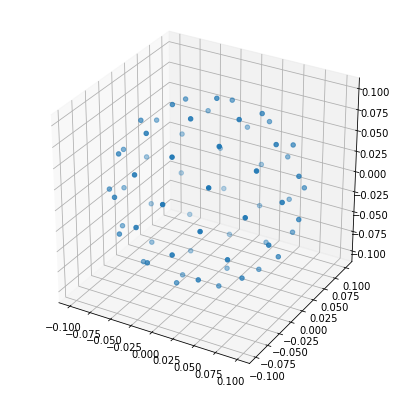

In [5]:
Q = 64
N = 7
f = 3500
c = 340
k = 2*np.pi*f/c

x_q = (1/1000)*np.array([92.87248504,97.24271681,92.94052753,67.76347524,46.46820924,9.15285677,16.67688232,-5.02914291,15.54210645,58.27853799,87.33600863,99.64542893,82.59577720,54.98970389,42.95035361,79.02718715,-0.95586134,33.60658337,65.84915205,78.68947327,74.95342300,72.69378055,38.47902000,28.04341953,-6.36020205,-37.96648209,-28.46820656,-51.81530182,-32.00307464,-17.18304345,31.60049464,66.12742186,-70.72036899,-83.65437631,-63.99281989,-46.44820610,-20.03621256,16.15417190,44.44449497,44.58369652,38.21016357,36.50458513,-3.30370367,-7.84654566,-43.40076966,-71.53207421,-95.16399794,-99.14743134,-81.93215260,-61.10065065,-25.65629260,4.49213395,-0.13248193,-3.55622011,-40.39615447,-49.62396458,-82.56077519,-98.00533545,-91.06001434,-63.61670849,-37.22899828,-44.36537931,-76.03920334,-77.61214918])
y_q = (1/1000)*np.array([-36.54799424,-17.67997233,25.97133639,60.22745018,89.60055179,100.31343530,83.80176637,56.78680720,15.35626685,7.29231653,-4.83700272,15.04420678,59.14819629,78.69874437,50.89088147,41.71228922,-61.29577860,-76.02460980,-73.02330695,-60.47573286,-31.47270636,13.44345713,46.16821875,81.86019988,96.70967011,94.19130453,85.44255118,52.16757609,20.29114238,-21.82779295,-30.33225330,-43.16196807,66.52571410,24.86705551,-6.83777624,-52.21818834,-87.10854741,-97.90565638,-90.71169051,-73.94625110,-41.98628516,1.34798521,25.61073808,65.94052756,77.22054084,70.14732512,35.54664859,-4.27623468,-35.83554645,-74.50518837,-98.29817356,-95.82336771,-69.21793652,-26.77784208,-0.89497560,41.14665773,36.55508289,-5.28656196,-45.05313807,-78.06984296,-80.86758033,-45.94490308,-5.12352453,-46.65830663])
z_q = (1/1000)*np.array([-19.01330166,23.53364837,31.78219672,45.86202861,11.61923617,-13.26649557,-54.97004229,-84.09831300,-99.22292072,-82.90352302,-51.68737758,-12.92363476,-1.41012952,-33.24454994,-76.73294800,-48.34613345,-81.02144071,-58.42444916,-25.57431947,21.75344873,60.94270370,69.69539246,81.91715691,53.24504012,30.48520193,-3.01734788,-47.02862599,-70.11617861,-94.26893844,-97.72845273,-91.67291393,-63.92783893,-29.92521968,-52.02052358,-78.61757958,-73.74540634,-48.30332446,-21.81937624,10.89201869,53.54256207,84.25968941,94.80589750,98.26360281,76.89498388,49.75863005,16.88416823,-1.67608756,-21.77293449,-48.22339662,-32.22184656,-1.33556193,33.47032914,74.37351486,97.94314918,93.21968527,78.53008784,46.58330510,26.25959796,-0.92116138,13.43778337,48.95912723,79.01480241,67.18890571,46.06426731])

r_a = np.sqrt(x_q[0]**2 + y_q[0]**2 + z_q[0]**2)
phi_q = np.arctan2(y_q, x_q)
theta_q = np.arccos(z_q/np.sqrt(x_q**2 + y_q**2 + z_q**2))
Y_q = harm(N, theta_q, phi_q)

plt.figure(figsize=(7,7)).add_subplot(111, projection='3d').scatter(x_q, y_q, z_q);
plt.show()

**a)** Uniform angle distribuition

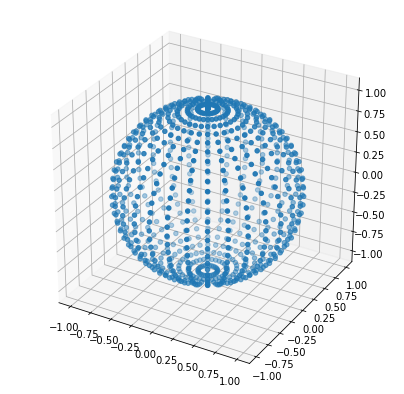

In [7]:
phi, theta  = np.meshgrid(np.arange(0, 2*np.pi, 2*np.pi/30), np.arange(0, np.pi, np.pi/30))
L = len(theta)*len(phi)
theta_l = np.reshape(theta, L)
phi_l = np.reshape(phi, L)
x, y, z = np.cos(phi_l)*np.sin(theta_l), np.sin(phi_l)*np.sin(theta_l), np.cos(theta_l);

plt.figure(figsize=(7,7)).add_subplot(111, projection='3d').scatter(x, y, z);
plt.show()

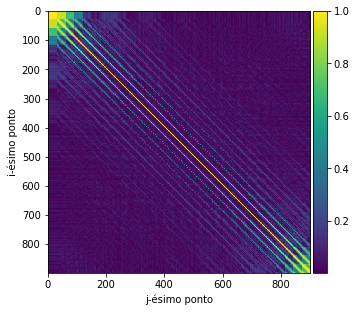

In [8]:
Y_l = harm(N, theta_l, phi_l)
A = sens_matrix(k*r_a, k*r_a, Y_l, Y_q)
G = gram(A)

fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(G, cmap='viridis')
plt.ylabel('i-ésimo ponto')
plt.xlabel('j-ésimo ponto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)

In [9]:
G_aux = G - np.diag(np.ones(L))
print('Mutual coherence = ', np.amax(G_aux))
print('Avareged coherence = ', np.mean(G))
print('Maximal sparsity level = ', (1/2)*(1+1/np.amax(G_aux)))

Mutual coherence =  1.0000000000000002
Avareged coherence =  0.0789978610689297
Maximal sparsity level =  0.9999999999999999


**b)** Nearly-uniform distribuition

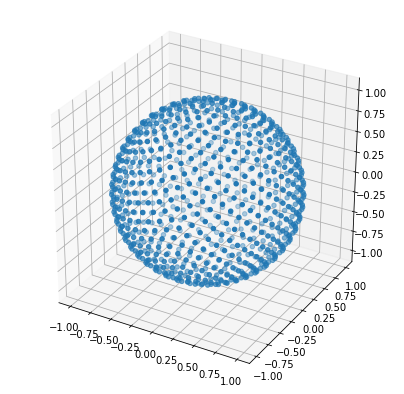

In [6]:
L = 900
theta_l, phi_l = dist(L)

x, y, z = np.cos(phi_l)*np.sin(theta_l), np.sin(phi_l)*np.sin(theta_l), np.cos(theta_l);

plt.figure(figsize=(7,7)).add_subplot(111, projection='3d').scatter(x, y, z);
plt.show()

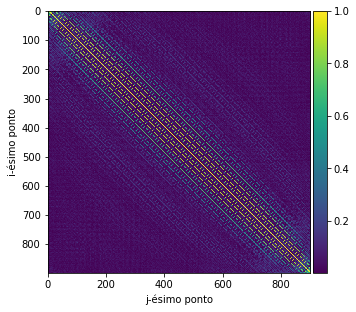

In [11]:
Y_l = harm(N, theta_l, phi_l)
A = sens_matrix(k*r_a, k*r_a, Y_l, Y_q)
G = gram(A)

fig, ax = plt.subplots(figsize=(5,5))
img = ax.imshow(G, cmap='viridis')
plt.ylabel('i-ésimo ponto')
plt.xlabel('j-ésimo ponto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img, cax=cax)

In [12]:
G_aux = G - np.diag(np.ones(L))
print('Mutual coherence = ', np.amax(G_aux))
print('Avareged coherence = ', np.mean(G))
print('Maximal sparsity level = ', (1/2)*(1+1/np.amax(G_aux)))

Mutual coherence =  0.9317220225186011
Avareged coherence =  0.06813801101628619
Maximal sparsity level =  1.0366407446809254


Comparing **a)** and **b)**, the nearly-uniform distribuition can lead to better results and, therefore, will be used as it follows.

The sparsity level does not alter with the number of points on the grid for $L > 73$, as it is shown below. For that reason and because $L < 73$ is not dense enough, it is chosen $L = 900$ at the simulation.

In [27]:
L = np.arange(2,901,1)
S = np.zeros(L.shape)

for i in range(L.shape[0]):
    theta_l, phi_l = dist(L[i])
    Y_l = harm(N, theta_l, phi_l)
    A = sens_matrix(k*r_a, k*r_a, Y_l, Y_q)
    G = gram(A)
    G_aux = G - np.diag(np.ones(L[i]))
    S[i] = np.int((1/2)*(1+1/np.amax(G_aux)))

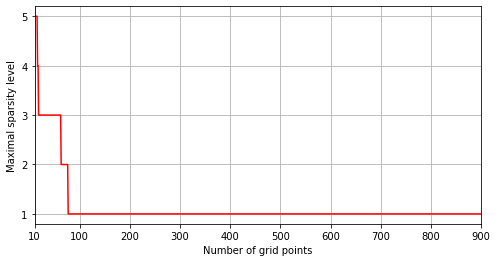

In [28]:
plt.figure(figsize=(8,4))
plt.plot(L[10:], S[10:], 'r')
plt.xlabel('Number of grid points')
plt.ylabel('Maximal sparsity level')
plt.xlim(10,900)
plt.xticks([10, 100, 200, 300, 400, 500, 600, 700, 800, 900])
plt.yticks([1,2, 3,  4, 5])
plt.grid(True)

## 5. Recovery Algorithms

### L2-norm minimization

The $\ell_2$-norm is a classic regularization method that solves the underdetermined system

\begin{equation}
\mathbf{p} = \mathbf{Ab};
\end{equation}
where $\mathbf{p}$ is the measured pressure, $\mathbf{A}$ is the sensing matrix and $\mathbf{b}$ is the variable vector that contains the sources directions and amplitudes; by imposing minimal $\ell_2$-norm of $\mathbf{b}$. This is known as least squares and is written as

\begin{equation}
\min_{\mathbf{b}}\|\mathbf{b}\|_2^2 \ \ \text{s. t.}\ \ \mathbf{p} = \mathbf{Ab}.
\end{equation}

Since we are dealing with practical siginals, noise is added to the measured pressure and the system is rewritten as

\begin{equation}
\tilde{\mathbf{p}} = \mathbf{Ab} + \mathbf{n}
\end{equation}
where $\mathbf{n}_{Q\times 1} = [n_1, \dots, n_Q]^T$ is the aditive noise. Therefore, the minimization is

\begin{equation}
\min_{\mathbf{b}}\|\mathbf{b}\|_2\ \ \text{s. a.}\ \ \|\tilde{\mathbf{p}} - \mathbf{Ab}\|_2 \leq \epsilon,
\label{eq.minl2_noise}
\end{equation}
where $\epsilon$ is the noise energy and is equal to $\|\mathbf{n}\|_2$. $\epsilon$ can be estimated through the signal to noise ratio (SNR): SNR $= 10\log_{10}(\|\mathbf{p}\|_2/\|\mathbf{n}\|_2)$.

In [7]:
def l2(p, A, e):
    delta = 1e-6
    L = A.shape[1]
    b_est = cp.Variable(shape=(L,1), complex=True)
    
    if e == 0:
        constraints = [A*b_est == p]
    else:
        constraints = [cp.norm(p - A*b_est, 2) <= e]
    obj = cp.Minimize(cp.norm(b_est, 2)**2)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.ECOS)
    print("status: {}".format(prob.status))
    
    return b_est.value

### L1-norm minimization

The $\ell_1$-norm minimization is defined as

\begin{equation}
\min_{\mathbf{b}}\|\mathbf{b}\|_1 \ \ \text{s. a.}\ \ \|\tilde{\mathbf{p}} - \mathbf{Ab}\|_2 \leq \epsilon.
\end{equation}

In [8]:
def l1(p, A, e):
    delta = 1e-6
    L = A.shape[1]
    b_est = cp.Variable(shape=(L,1), complex=True)

    if e == 0:
        constraints = [A*b_est == p]
    else:
        constraints = [cp.norm(p - A*b_est, 2) <= e]
    obj = cp.Minimize(cp.norm(b_est, 1))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.ECOS)
    print("status: {}".format(prob.status))
    
    return b_est.value

A way to exemplify the $\ell_1$-norm sparsity is plotting the solution of the following system in $\mathbb{R}^2$:

\begin{equation}
\mathbf{Ab} = \begin{bmatrix}
2 & 4
\end{bmatrix}\begin{bmatrix}
b_1 \\
b_2
\end{bmatrix} = \mathbf{p} = [1],
\end{equation}
using both the $\ell_1$ and the $\ell_2$ norms to find a single solution. The possible solutions for $2b_1 + 4b_2 = 1$ are along the dashed line below with $\epsilon = 0$.

In [9]:
A = np.array([[2, 4]])
p = np.array([1])
e = 0

b_l1 = l1(p, A, e)
b_l2 = l2(p, A, e)

status: optimal
status: optimal


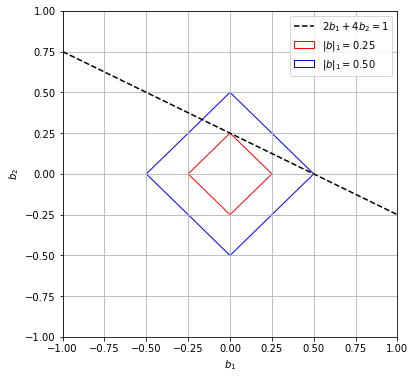

In [10]:
#L1-norm minimization

fig, ax = plt.subplots(figsize=(6,6))

norm = cp.norm(b_l1, 1).value
width = np.sqrt(norm**2+norm**2)
height = np.sqrt(norm**2+norm**2)
ax.add_patch(Rectangle((0, -norm), width, height, color='r', label='$|b|_1 = 0.25$', angle=45, fill=False))

norm = 0.5
width = np.sqrt(norm**2+norm**2)
height = np.sqrt(norm**2+norm**2)
ax.add_patch(Rectangle((0, -norm), width, height, color='b', label='$|b|_1 = 0.50$', angle=45, fill=False))

b1 = np.arange(-1, 1+0.01, 0.01)
b2 = (-2*b1+1)/4
ax.plot(b1, b2, '--k', label='$2b_1 + 4b_2 = 1$')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.grid(True)
ax.set_ylabel('$b_2$')
ax.set_xlabel('$b_1$')
ax.legend()
plt.show()

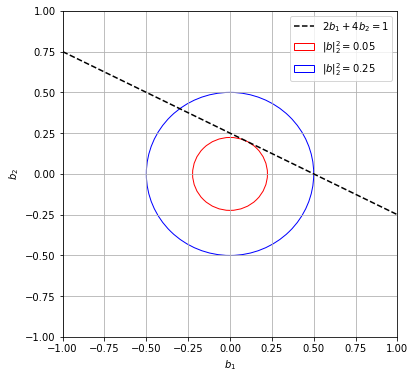

In [11]:
#L2-norm minimization

fig, ax = plt.subplots(figsize=(6,6))

radius = cp.norm(b_l2, 2).value
ax.add_patch(Circle((0, 0), radius, color='r', label='$|b|_2^2 = 0.05$', fill=False))

radius = 0.5
ax.add_patch(Circle((0, 0), radius, color='b', label='$|b|_2^2 = 0.25$', fill=False))

b1 = np.arange(-1, 1+0.01, 0.01)
b2 = (-2*b1+1)/4
ax.plot(b1, b2, '--k', label='$2b_1 + 4b_2 = 1$')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.grid(True)
ax.set_ylabel('$b_2$')
ax.set_xlabel('$b_1$')
ax.legend()
plt.show()

### LASSO

The Least Absolute Shrinkage and Selection Operator (LASSO) equation is written as

\begin{equation}
\min_{\mathbf{b}}\frac{1}{2}\|\tilde{\mathbf{p}} - \mathbf{Ab}\|_2^2 + \lambda\|\mathbf{b}\|_1,
\end{equation}
where $\lambda \geq 0$ is the regulator. The first entry of $\mathbf{b}$ is released when $\lambda = \|\mathbf{A}^H\tilde{\mathbf{p}}\|_{\infty}$. Lowering $\lambda$ decreases the sparsity of $\mathbf{b}$. Here, it is done the LASSO path, which analyzes the variation of the amplitudes $b_l$ and the sparsity level of $\mathbf{b}$ in funcion of $\lambda$. 

In [12]:
def LASSO(p, A):
    L = A.shape[1]
    lmbd_max = np.max(abs(np.matmul(np.conjugate(A.T), p)))
    lmbd = np.arange(0, np.int(lmbd_max)+1.1, 0.1)
    non_zeros = np.zeros((lmbd.shape[0]))
    amp = np.zeros((L, 1, lmbd.shape[0]))

    for i in range(lmbd.shape[0]):
        delta = 1e-6
        b_est = cp.Variable(shape=(L,1), complex=True)

        obj = cp.Minimize(lmbd[i]*cp.norm(b_est, 1) + (1/2)*cp.norm(p- A*b_est, 2)**2)
        prob = cp.Problem(obj)
        prob.solve(solver=cp.ECOS)

        non_zeros[i] = np.where(abs(b_est.value) >= delta)[0][:].shape[0]
        amp[:,:,i] = abs(b_est.value)
        
    return non_zeros, amp

### OMP

The Orthogonal Matching Pursuit is a greedy algorithm that searchs sequentially the non-zero entry present in a measurement.

**Input**: **A**, $\tilde{\mathbf{p}}$, $S$.

**Start**: Residue $\mathbf{r}_0 = \tilde{\mathbf{p}}$, set $\Upsilon_0 = \varnothing$ with indexes of non-zero entries of $\mathbf{b}$, matrix $\tilde{\mathbf{A}}_0 = []$ of selected columns of **A**, $\mathbf{\hat{b}} = \mathbf{0}$, counter $t = 1$.

**While** $t \leq S$:

1. Find the index $\upsilon_i$
\begin{equation}
\upsilon_t = \text{argmax}_{j=1,\dots,L}|\langle \mathbf{r}_{t-1},\mathbf{a}_j^*\rangle|; 
\end{equation}


2. Augment $\Upsilon_t = \Upsilon_{t-1} \cup \upsilon_t$ and $\tilde{\mathbf{A}}_t = [\tilde{\mathbf{A}}_{t-1} \ {\mathbf{a}}_{\upsilon_t}]$;


3. Find $\hat{\mathbf{x}}$

\begin{equation}
\min_{\mathbf{x}} \|\tilde{\mathbf{p}} - \tilde{\mathbf{A}}_t\mathbf{x}\|_2;
\end{equation}


4. Obtain $\mathbf{r}_t = \tilde{\mathbf{p}} - \tilde{\mathbf{A}}_t\hat{\mathbf{x}}_i$;


5. Increase $t$.

**Output**: $\mathbf{\hat{b}}$ has non-zero indexes listed in$\Upsilon_S$ and the estimated entry $\hat{b}_{\upsilon_i}$ is the $i$-th element of $\hat{\mathbf{x}}_S$.

In [13]:
def OMP(S, p, A):
    Q = p.shape[0]
    Ã = np.zeros((Q, S), dtype='complex')
    r = np.copy(p)
    U = np.zeros((S))
    L = A.shape[1]
    b_est = np.zeros((L,1), dtype='complex')
    delta = 1e-6

    for i in range(S):
        g = np.argmax(abs(np.matmul(np.conjugate(A.T),r)))
        U[i] = g
        Ã[:,[i]] = A[:,[g]]
        
        x = cp.Variable(shape=(i+1,1), complex=True)
        obj = cp.Minimize(cp.norm(p - Ã[:,:i+1]*x, 2))
        prob = cp.Problem(obj)
        prob.solve(solver=cp.ECOS)
        print("status: {}".format(prob.status))
        
        r = p - np.matmul(Ã[:,:i+1],x.value)
        
    for i in range(S):
        b_est[np.int(U[i])][0] = x.value[i][0]
        
    return b_est

# Simulation

## 1. Close Sources

A sound scene with 3 plane waves of 3500Hz was simulated. Their respective amplitudes and directions are: [1.00, 0.70, 0.50] and [$\Omega_{100}=(39.04^\circ, 220.47^\circ)$, $\Omega_{325} = (73.94^\circ, 241.22^\circ)$, $\Omega_{800}  = (141.16^\circ,$ $85.04^\circ)$]. The chosen grid has nearly-uniform distribuition and $L=900$ different directions as discussed above. The simulated noise is a random sequence with Gaussian distribuition and SNR = 20 dB.

100
θ =  39.04361636760739 ϕ =  220.46971297119237
325
θ =  73.93863873302956 ϕ =  241.22280171267877
800
θ =  141.15895539370763 ϕ =  85.03487794470634


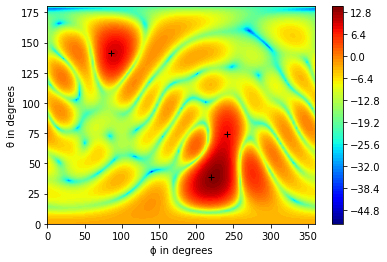

In [18]:
L = 900
theta_l, phi_l = dist(L)
Y_l = harm(N, theta_l, phi_l)
A = sens_matrix(k*r_a, k*r_a, Y_l, Y_q)

b_a = np.array([1+0*1j, 0.7+0*1j, 0.5+0*1j])
b_l = np.array([100, 325, 800])
b = np.zeros((L, 1), dtype='complex')

for i in range(b_a.shape[0]):
    l = b_l[i]
    b[l][0] = b_a[i]

p = np.matmul(A, b)

#Generate noise
#SNR = 20
#SNR_lin = 10**((SNR)/10)
#p_q2 = cp.norm(p_q, 2).value
#n2 = p_q2/SNR_lin
#noise = np.random.standard_normal((64,1))*np.sqrt(n2)

#A saved Gaussian noise generated as above
noise = np.array([[-0.37398654,  0.53508969,  0.23710075, -0.76595993, -0.10742499,
          0.18649644, -0.28852733, -0.16655358, -0.0193461 ,  0.19924107,
         -0.01744733,  0.16727264, -0.24452648, -0.17032441, -0.57297673,
         -0.30339784,  0.42941807, -0.1978721 , -0.27904757, -0.30157045,
         -0.01540471,  0.21401375,  0.33538457, -0.11112475, -0.06276459,
         -0.31605248, -0.03668139,  0.13355574, -0.17327418,  0.26137159,
          0.01431233,  0.02984489, -0.41106218, -0.32741734,  0.02280683,
         -0.03198547, -0.48798405, -0.30575089,  0.26135944, -0.37273886,
          0.00310794,  0.06751159,  0.24902737, -0.04809595,  0.01627591,
         -0.15539654, -0.15265062,  0.16710653,  0.49975913,  0.53093809,
          0.05949748, -0.06564984, -0.26526353, -0.56716557, -0.30007437,
          0.34723385,  0.04454196, -0.23716939,  0.19903726, -0.30941402,
          0.63036041,  0.06418417,  0.15262732,  0.37612644]]).T

e = cp.norm(noise, 2).value
p += noise
pnm = fourier(p, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

plt.figure(figsize=(6,4))
for i in range(b_a.shape[0]):
    l = b_l[i]
    print(l)
    print('θ = ',(180/np.pi)*theta_l[l], 'ϕ = ', (180/np.pi)*phi_l[l])
    plt.plot((180/np.pi)*phi_l[l], (180/np.pi)*theta_l[l], color='black', marker='+')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar= plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### L2-norm minimization

status: optimal


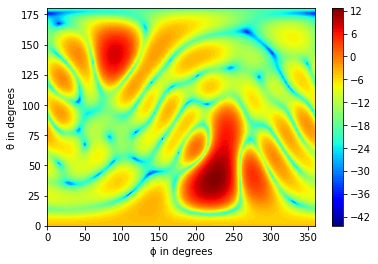

In [21]:
b_l2 = l2(p, A, e)
p_l2 = np.matmul(A, b_l2)
pnm = fourier(p_l2, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

plt.figure(figsize=(6,4))
cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### L1-norm minimization

status: optimal


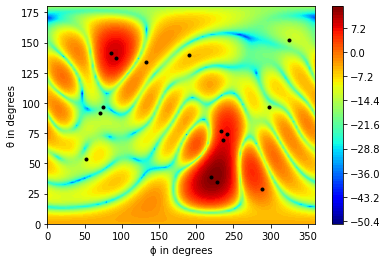

In [22]:
b_l1 = l1(p, A, e)
p_l1 = np.matmul(A, b_l1)
pnm = fourier(p_l1, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

#A treshold is chosen to show the results
D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

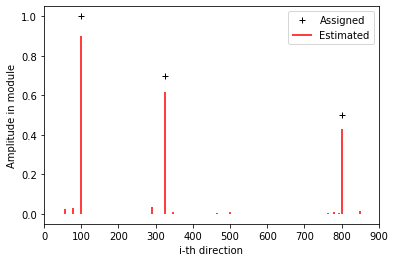

In [23]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_l1) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

x = abs(b_l)
y = abs(b_a)

plt.plot(x, y, 'k+')
plt.legend(('Assigned', 'Estimated'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

### L1-norm minimization: Noiseless

status: optimal


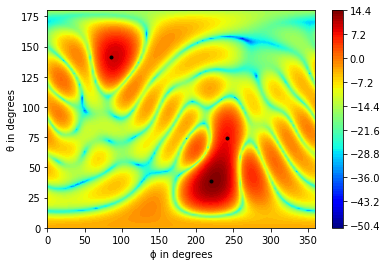

In [24]:
b_l1 = l1(np.matmul(A, b), A, 0)
p_l1 = np.matmul(A, b_l1)
pnm = fourier(p_l1, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

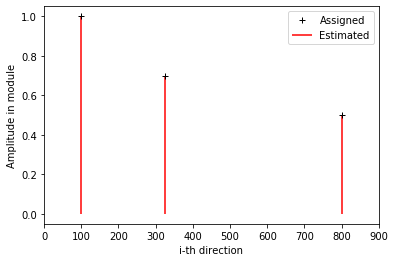

In [25]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_l1) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

x = abs(b_l)
y = abs(b_a)

plt.plot(x, y, 'k+')
plt.legend(('Assigned', 'Estimated'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

### LASSO

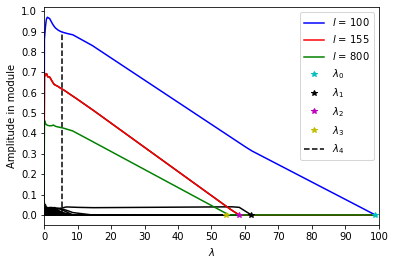

In [44]:
non_zeros, amp = LASSO(p, A)
lmbd_max = np.max(abs(np.matmul(np.conjugate(A.T), p)))
lmbd = np.arange(0, np.int(lmbd_max)+1.1, 0.1)
plt.figure(figsize=(6,4))
for i in range(L):
    if i != 100 and i != 155 and i != 800:
        plt.plot(lmbd, np.absolute(amp[i][0][:]), 'k')
plt.plot(lmbd, np.absolute(amp[100][0][:]), 'b', label='$l$ = 100')
plt.plot(lmbd, np.absolute(amp[325][0][:]), 'r', label='$l$ = 325')
plt.plot(lmbd, np.absolute(amp[800][0][:]), 'g', label='$l$ = 800')
plt.plot(98.91, 0, '*c', label='$\lambda_0$')
plt.plot(61.84, 0, '*k', label='$\lambda_1$')
plt.plot(58.25, 0, '*m', label='$\lambda_2$')
plt.plot(54.20, 0, '*y', label='$\lambda_3$')
plt.vlines(5.50, 0, abs(0.89716183-0.01616186j), colors='k', linestyles='dashed', label='$\lambda_4$')

plt.ylabel('Amplitude in module')
plt.xlabel('$\lambda$')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 110, 10))
plt.xlim(0, 100)
plt.legend(loc='upper right')

status: optimal


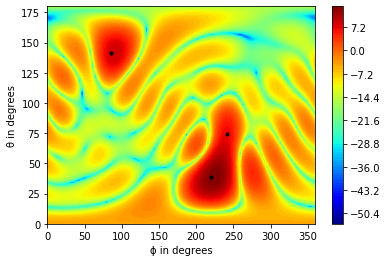

In [26]:
delta = 1e-6
b_lasso = cp.Variable(shape=(L,1), complex=True)

obj = cp.Minimize(5.5*cp.norm(b_lasso, 1) + (1/2)*cp.norm(p - A*b_lasso, 2)**2)
prob = cp.Problem(obj)
prob.solve(solver=cp.ECOS)
print("status: {}".format(prob.status))

p_lasso = np.matmul(A, b_lasso.value)
pnm = fourier(p_lasso, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### OMP

status: optimal
status: optimal
status: optimal


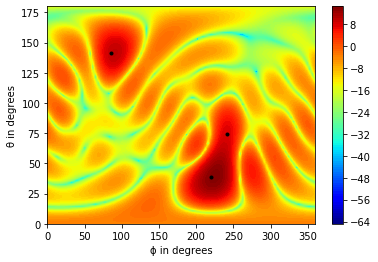

In [27]:
b_omp = OMP(3, p, A)
p_omp = np.matmul(A, b_omp)
pnm = fourier(p_omp, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_omp) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_omp) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

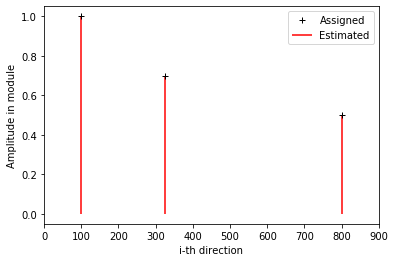

In [28]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_omp) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

x = abs(b_l)
y = abs(b_a)

plt.plot(x, y, 'k+')
plt.legend(('Assigned', 'Estimated'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

## 2. Overlaid Sources

Now, two of the sources are visually overlaid. Their respective amplitudes and directions are: [1.00, 0.70, 0.50] and [$\Omega_{100}=(39.04^\circ, 220.47^\circ)$, $\Omega_{155} = (49.12^\circ, 217.54^\circ)$, $\Omega_{800}  = (141.16^\circ,$ $85.04^\circ)$]. The other caracteristics are the same as in **2. Close Sources**.

100
θ =  39.04361636760739 ϕ =  220.46971297119237
155
θ =  49.12246179570516 ϕ =  217.54269021910633
800
θ =  141.15895539370763 ϕ =  85.03487794470634


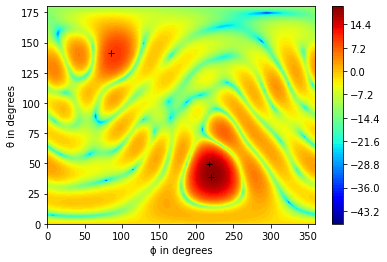

In [19]:
b_a = np.array([1+0*1j, 0.7+0*1j, 0.5+0*1j])
b_l = np.array([100, 155, 800])
b = np.zeros((L, 1), dtype='complex')

for i in range(b_a.shape[0]):
    l = b_l[i]
    b[l][0] = b_a[i]

p = np.matmul(A, b)

#Generate noise
#SNR = 20
#SNR_lin = 10**((SNR)/10)
#p_q2 = cp.norm(p_q, 2).value
#n2 = p_q2/SNR_lin
#noise = np.random.standard_normal((64,1))*np.sqrt(n2)

#A saved Gaussian noise generated as above
noise = np.array([[ 1.81327072e-01, -2.40433058e-01,  5.43444726e-02,
        -2.60919693e-03,  5.09521695e-02,  5.53560773e-02,
         5.07006134e-01,  1.61581059e-01,  8.29004328e-02,
         2.10052552e-01,  5.18794283e-02,  2.60972279e-01,
         8.09914278e-01,  8.72558986e-01, -2.34352466e-01,
        -1.78332853e-01,  2.38028725e-01,  3.51326950e-01,
        -3.74199375e-02,  3.32139798e-01, -6.73740776e-01,
        -4.36198561e-01, -1.52207850e-01,  1.23315876e+00,
        -4.93751851e-02,  4.98440075e-01,  1.38435631e-01,
        -2.03223004e-01,  1.70111297e-01,  3.01544288e-01,
        -1.23959374e-01,  1.24072315e-01,  5.68675213e-01,
         3.65567194e-01,  3.76324335e-01,  1.96977342e-01,
        -8.40987011e-01,  7.09049094e-01,  1.05398282e+00,
         7.42276345e-01,  9.47914841e-01, -6.18391710e-01,
         1.41213627e-01, -2.48753470e-02,  1.84262790e-01,
         2.27447551e-01,  1.12372813e+00,  5.75978578e-02,
         6.03665390e-01, -2.47058046e-01, -5.58567169e-02,
         3.39977101e-01,  1.38251804e-03,  5.79039732e-01,
         1.62788687e+00, -1.60543375e-01,  4.39835441e-01,
         4.43765231e-01,  4.09464759e-02,  6.24422426e-01,
         1.02828090e-01,  6.80013126e-01, -4.97013956e-01,
        -5.03918538e-02]]).T

e = cp.norm(noise, 2).value
p += noise
pnm = fourier(p, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

plt.figure(figsize=(6,4))
for i in range(b_a.shape[0]):
    l = b_l[i]
    print(l)
    print('θ = ',(180/np.pi)*theta_l[l], 'ϕ = ', (180/np.pi)*phi_l[l])
    plt.plot((180/np.pi)*phi_l[l], (180/np.pi)*theta_l[l], color='black', marker='+')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar= plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### L2-norm minimization

status: optimal


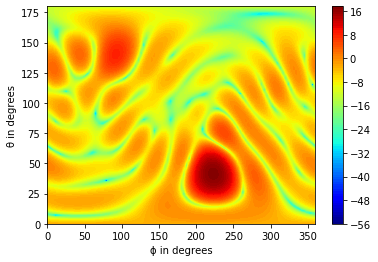

In [20]:
b_l2 = l2(p, A, e)
p_l2 = np.matmul(A, b_l2)
pnm = fourier(p_l2, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

plt.figure(figsize=(6,4))
cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### L1-norm minimization

status: optimal


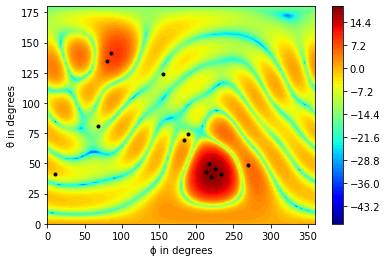

In [21]:
b_l1 = l1(p, A, e)
p_l1 = np.matmul(A, b_l1)
pnm = fourier(p_l1, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

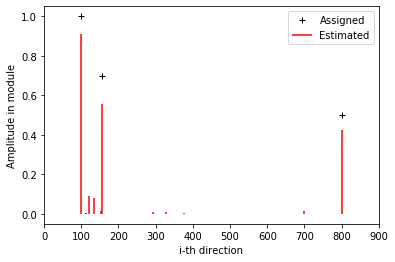

In [22]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_l1) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

x = abs(b_l)
y = abs(b_a)

plt.plot(x, y, 'k+')
plt.legend(('Assigned', 'Estimated'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

### L1-norm minimization: Noiseless

status: optimal


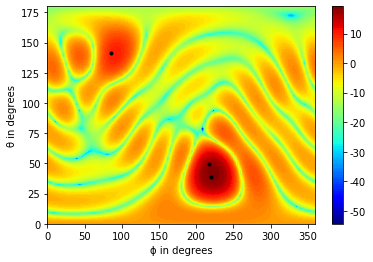

In [61]:
b_l1 = l1(np.matmul(A, b), A, 0)
p_l1 = np.matmul(A, b_l1)
pnm = fourier(p_l1, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

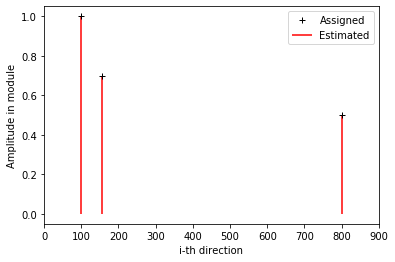

In [62]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_l1) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

x = abs(b_l)
y = abs(b_a)

plt.plot(x, y, 'k+')
plt.legend(('Assigned', 'Estimated'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

### LASSO

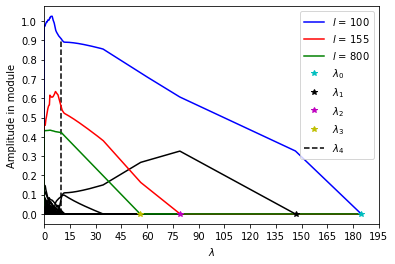

In [67]:
non_zeros, amp = LASSO(p, A)
lmbd_max = np.max(abs(np.matmul(np.conjugate(A.T), p)))
lmbd = np.arange(0, np.int(lmbd_max)+1.1, 0.1)
plt.figure(figsize=(6,4))
for i in range(L):
    if i != 100 and i != 155 and i != 800:
        plt.plot(lmbd, np.absolute(amp[i][0][:]), 'k')
plt.plot(lmbd, np.absolute(amp[100][0][:]), 'b', label='$l$ = 100')
plt.plot(lmbd, np.absolute(amp[155][0][:]), 'r', label='$l$ = 155')
plt.plot(lmbd, np.absolute(amp[800][0][:]), 'g', label='$l$ = 800')
plt.plot(184.67, 0, '*c', label='$\lambda_0$')
plt.plot(146.44, 0, '*k', label='$\lambda_1$')
plt.plot(79.06, 0, '*m', label='$\lambda_2$')
plt.plot(55.89, 0, '*y', label='$\lambda_3$')
plt.vlines(10.08, 0, abs(0.90723123-0.00463219j), colors='k', linestyles='dashed', label='$\lambda_4$')

plt.ylabel('Amplitude in module')
plt.xlabel('$\lambda$')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 210, 15))
plt.xlim(0, 195)
plt.legend(loc='upper right')

status: optimal


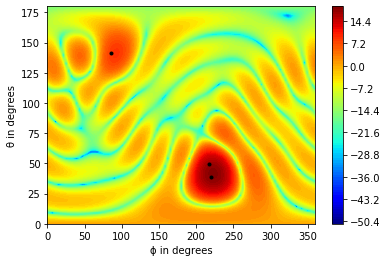

In [68]:
delta = 1e-6
b_lasso = cp.Variable(shape=(L,1), complex=True)

obj = cp.Minimize(10.08*cp.norm(b_lasso, 1) + (1/2)*cp.norm(p - A*b_lasso, 2)**2)
prob = cp.Problem(obj)
prob.solve(solver=cp.ECOS)
print("status: {}".format(prob.status))

p_lasso = np.matmul(A, b_lasso.value)
pnm = fourier(p_lasso, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### OMP

In [21]:
b_omp = OMP(3, p, A)
p_omp = np.matmul(A, b_omp)
pnm = fourier(p_omp, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_omp) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_omp) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

status: optimal
status: optimal
status: optimal


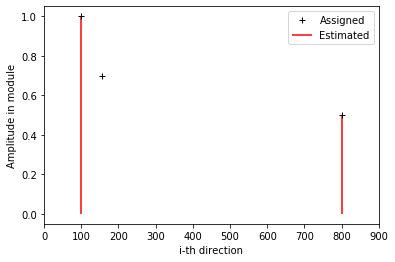

In [70]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_omp) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

x = abs(b_l)
y = abs(b_a)

plt.plot(x, y, 'k+')
plt.legend(('Assigned', 'Estimated'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()